In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
import warnings
import pydot as pyd
import seaborn as sns
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

warnings.simplefilter(action = 'ignore', category = FutureWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";

# GPUid to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Insert initial parameters
batch_size = 64
img_height, img_width = 224, 224
n_classes = 3

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True,
                                   rotation_range = 45,
                                   brightness_range = [0.5, 1.5],
                                   fill_mode = 'constant',
                                   samplewise_center = True,
                                   rescale = 1./255)

test_datagen = ImageDataGenerator(samplewise_center = True,
                                  rescale = 1./255)

train = train_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_RGB/dataset224_t1ce_frontal/train', 
                                          classes = ['G2','G3','G4'], color_mode = 'rgb', 
                                          class_mode = 'categorical', 
                                          target_size = (img_height, img_width), 
                                          batch_size = batch_size, seed = 123)
validation = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_RGB/dataset224_t1ce_frontal/val', 
                                              classes = ['G2','G3','G4'], color_mode = 'rgb',
                                              class_mode = 'categorical', 
                                              target_size = (img_height, img_width), 
                                              batch_size = batch_size, seed = 123)
test = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_RGB/dataset224_t1ce_frontal/test', 
                                        classes = ['G2','G3','G4'], color_mode = 'rgb',
                                        shuffle = False, class_mode = 'categorical', 
                                        target_size = (img_height, img_width), 
                                        batch_size = batch_size)

Found 6157 images belonging to 3 classes.
Found 1560 images belonging to 3 classes.
Found 578 images belonging to 3 classes.


In [4]:
# Use class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train.classes), 
                                                  y = train.classes)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3) (64, 3)
-0.2989816


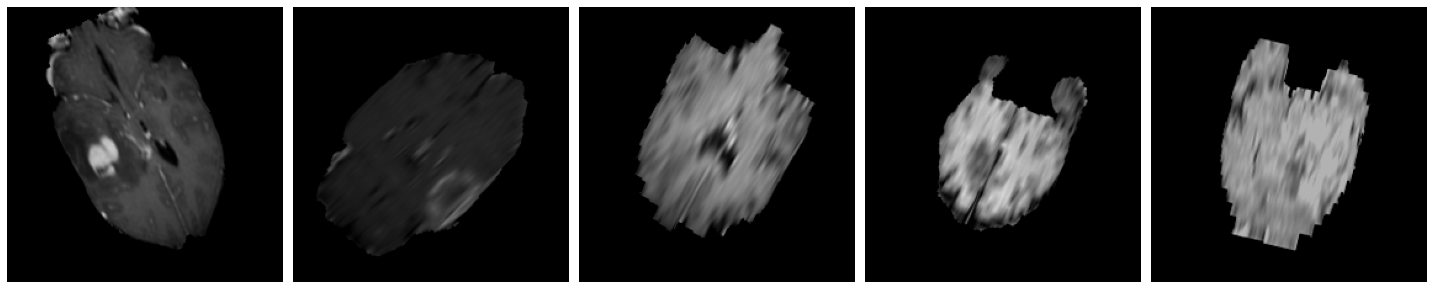

In [5]:
x_train, y_train = next(iter(train))
print(x_train.shape, y_train.shape)
print(x_train.min())

# Plot the images for fun
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in enumerate(axes):
        ax.imshow(images[img,:,:], cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(x_train[:1000])

In [6]:
# Load base model
resnet_50 = ResNet50(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

freeze_until_layer = 100

# Freeze all layers before the `freeze_until_layer` layer
for layer in resnet_50.layers[:freeze_until_layer]:
    layer.trainable = False

x = resnet_50.output
x = Flatten()(x)
x = Dense(20, activation = 'relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = resnet_50.input, outputs = predictions)
model.summary()

2022-04-21 10:00:19.205392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 10:00:19.206031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 10:00:19.206235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-21 10:00:19.206268: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

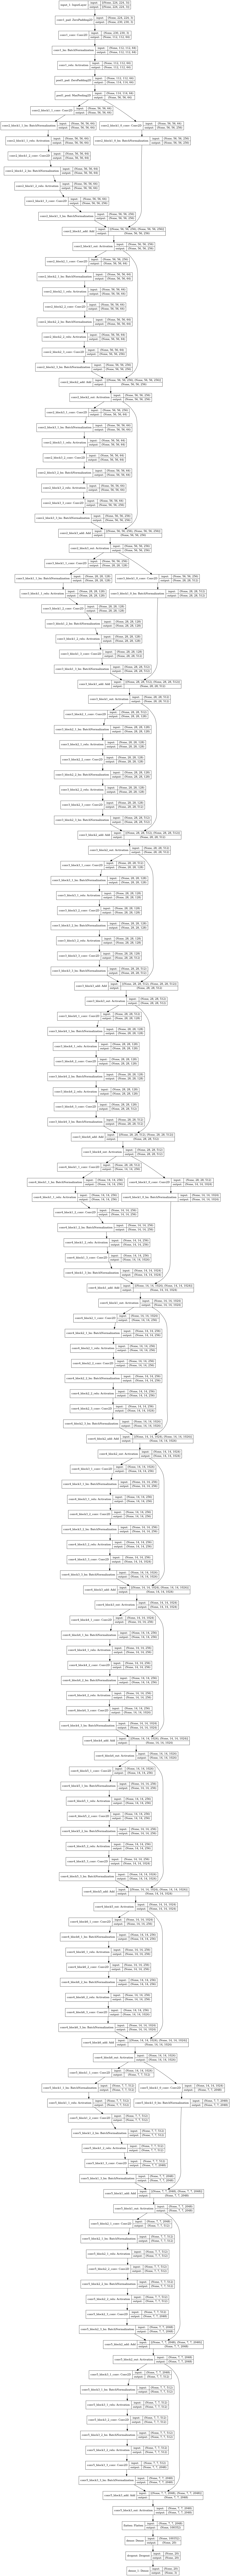

In [7]:
plot_model(model, to_file = 'resnet50_plot_t1ce_frontal.png', show_shapes = True, show_layer_names = True)

In [8]:
# Save best model
checkpoint_path = '/local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_frontal.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                verbose = 1,
                                                save_best_only = True)

# Save log for history
# append: True: append if file exists (useful for continuing training)//False: overwrite existing file
csv_logger = CSVLogger('/local/data1/elech646/code/train_logs/resnet50_transfer_history_t1ce_frontal.log', 
                       separator = ',', append = True)

# Reduce learning rate if val_accuracy is not improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1,
                              patience = 5, min_lr = 0.000001)
es = EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                   patience = 15)

In [9]:
# Compile model
model.compile(Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 35
start = timer()

history = model.fit(train, steps_per_epoch = len(train.labels) // batch_size, verbose = 1,
                    epochs = epochs, validation_data = validation,
                    validation_steps = len(validation.labels) // batch_size,
                    callbacks = [es, reduce_lr, checkpoint, csv_logger])

end = timer()
print("Training time: %.2f s\n" % (end - start))

2022-04-21 10:00:58.238116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-21 10:00:58.238444: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4100000000 Hz


Epoch 1/35


2022-04-21 10:01:00.350913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-04-21 10:01:00.821444: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


96/96 [==============================] - 50s 491ms/step - loss: 1.1524 - accuracy: 0.4465 - val_loss: 1.1901 - val_accuracy: 0.4167

Epoch 00001: val_accuracy improved from -inf to 0.41667, saving model to /local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_frontal.h5
Epoch 2/35
96/96 [==============================] - 48s 495ms/step - loss: 1.0348 - accuracy: 0.4542 - val_loss: 1.2115 - val_accuracy: 0.4974

Epoch 00002: val_accuracy improved from 0.41667 to 0.49740, saving model to /local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_frontal.h5
Epoch 3/35
96/96 [==============================] - 46s 480ms/step - loss: 1.0180 - accuracy: 0.4741 - val_loss: 1.1167 - val_accuracy: 0.3249

Epoch 00003: val_accuracy did not improve from 0.49740
Epoch 4/35
96/96 [==============================] - 46s 482ms/step - loss: 0.9865 - accuracy: 0.5012 - val_loss: 1.0459 - val_accuracy: 0.5664

Epoch 00004: val_accuracy improved from 0.49740 to 0.56641, saving model to /local/data

1st training:  

Data augmentation: only brightness adjustments

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(10, activation = 'relu')(x)
        x = Dropout(0.3)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64 

number of epochs = 35

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 373.91 s $\approx 6$ min

test accuracy: 0.6354 (overfit)

------------------------------------------------------------------------------------------------------------------

2nd training:

Data augmentation: horizontal+vertical flip, 45 degree rotation, `brightness_range = [0.5, 1.5]`, `fill_mode = 'constant'`

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(20, activation = 'relu')(x)
        x = Dropout(0.3)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64 

number of epochs = 35

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 1414.84 s $\approx $ min

test accuracy: 0.6267

In [10]:
score = model.evaluate(test, steps = len(test.labels) // batch_size, verbose = 0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.8899
Test accuracy: 0.6267


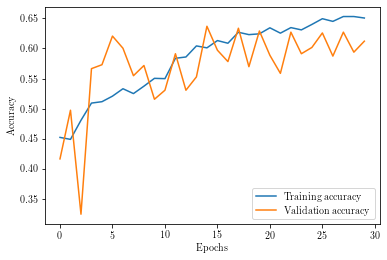

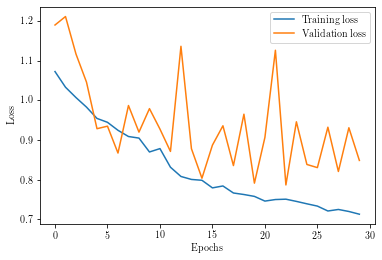

In [12]:
# Plot training + validation accuracy per epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(len(acc))

# for fancy LaTeX style plots
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

# Plot accuracy
plt.plot(n_epochs, acc, label = 'Training accuracy')
plt.plot(n_epochs, val_acc, label = 'Validation accuracy')
#plt.title('1st training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.savefig('ResNet50_2nd_training_t1ce_frontal_acc.png', dpi = 300)
plt.show()

# Plot loss
plt.plot(n_epochs, loss, label = 'Training loss')
plt.plot(n_epochs, val_loss, label = 'Validation loss')
#plt.title('1st training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.savefig('ResNet50_2nd_training_t1ce_frontal_loss.png', dpi = 300)
plt.show()

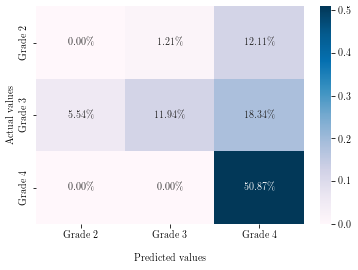

In [13]:
# Get true labels
y_true = test.classes

# Get rounded predictions
y_pred = np.argmax(model.predict(test), axis = 1) 

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

#ax = sns.heatmap(cm, annot = True, cmap = 'Blues')
ax = sns.heatmap(cm / np.sum(cm), annot = True, fmt = '.2%', cmap = 'PuBu')
for t in ax.texts: 
    t.set_text(t.get_text().replace('%', '\%'))
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values ');
# list must be in alphabetical order
ax.xaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
ax.yaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
plt.savefig('ResNet50-2nd_Training_CM_t1ce_frontal.png', dpi = 300)
plt.show()

In [14]:
# Print classification report
print(classification_report(y_true, y_pred))

# Save the classification report
clsf_report = pd.DataFrame(classification_report(y_true = y_true, y_pred = y_pred, output_dict = True)).transpose()
clsf_report.to_csv('Classification Report-ResNet50-2nd Training on t1ce frontal.csv', index = True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.91      0.33      0.49       207
           2       0.63      1.00      0.77       294

    accuracy                           0.63       578
   macro avg       0.51      0.44      0.42       578
weighted avg       0.64      0.63      0.57       578

